In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy
import galsim

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.lenses import lens_util
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure

In [2]:
print(f'Collecting lenses...')
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir
lens_list = lens_util.get_detectable_lenses(pipeline_dir, suppress_output=False)
lens_list = [lens for lens in lens_list if lens.snr > 150]
print(f'Collected {len(lens_list)} lenses.')

100%|██████████| 18/18 [00:00<00:00, 22.51it/s]

Collected 2 lenses.


In [3]:
lens = np.random.choice(lens_list)
print(lens.snr)

159.6262027523527


In [4]:
# lens = SampleStrongLens()
roman = Roman()

band = 'F106'
scene_size = 5  # arcsec
oversample = 5
config = {'sca': 1,
          'sca_position': (2048, 2048)}
exposure_time = 10000

rng = galsim.UniformDeviate(42)

In [5]:
image_x, image_y = lens.get_image_positions(pixel_coordinates=False)
pprint(image_x)
pprint(image_y)

array([ 0.36499933, -0.03972781])
array([-0.354134  ,  0.06827797])


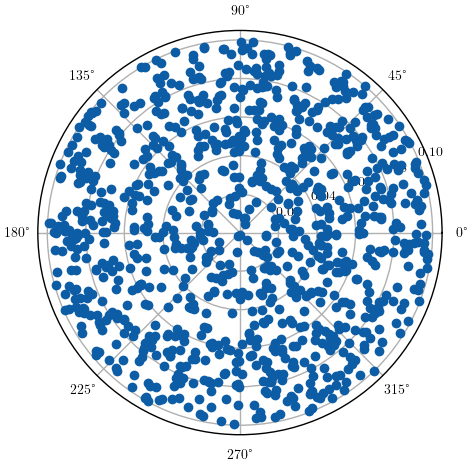

In [6]:
coords = []
for i in range(1000):
    r = 0.1 * np.sqrt(np.random.random_sample())
    theta = 2 * np.pi * np.random.random_sample()
    coords.append((theta, r))

f, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot([x[0] for x in coords], [x[1] for x in coords], 'o')
ax.set_aspect('equal')
plt.show()

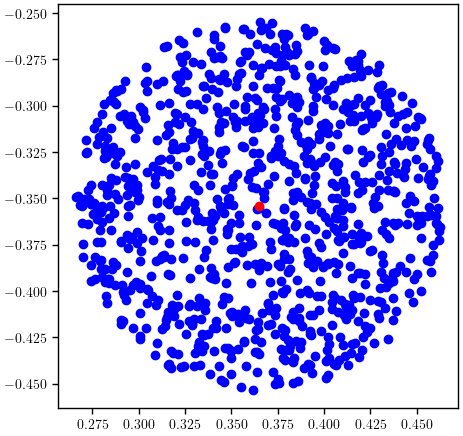

In [7]:
def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

num_images = len(image_x)
rand_idx = np.random.randint(0, num_images)
halo_x = image_x[rand_idx]
halo_y = image_y[rand_idx]

_, ax = plt.subplots()

halo_coords = []
for i in range(1000):
    theta, r = coords[i]
    x, y = polar_to_cartesian(r, theta)
    halo_coords.append((halo_x + x, halo_y + y))
    ax.plot(halo_x + x, halo_y + y, 'o', color='blue')

ax.plot(halo_x, halo_y, 'o', color='red')

ax.set_aspect('equal')
plt.show()

In [12]:
m200 = 1e11
concentration = 6

Rs_angle, alpha_Rs = lens.lens_cosmo.nfw_physical2angle(M=m200, c=concentration)
print(Rs_angle, alpha_Rs)

rand_idx = np.random.randint(0, len(halo_coords))
halo_x, halo_y = halo_coords[rand_idx]
print(halo_x, halo_y)

subhalo_type = 'TNFW'
kwargs_subhalo = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': halo_x, 'center_y': halo_y, 'r_trunc': 5 * Rs_angle}

3.9157661369148626 0.02427081464688264
0.3078802116400106 -0.37252473790494806


Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001014 by Roman in F106 band


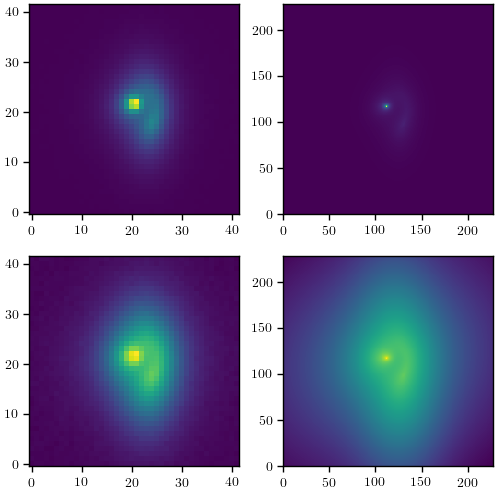

In [13]:
lens_no_subhalo = deepcopy(lens)
synth_no_subhalo = SyntheticImage(lens_no_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, **config)
exposure_no_subhalo = Exposure(synth_no_subhalo, exposure_time=exposure_time, rng=rng, **config, return_noise=True)

poisson_noise = exposure_no_subhalo.poisson_noise
dark_noise = exposure_no_subhalo.dark_noise
read_noise = exposure_no_subhalo.read_noise

_, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(exposure_no_subhalo.exposure)
ax[1, 0].imshow(np.log10(exposure_no_subhalo.exposure))
ax[0, 1].imshow(synth_no_subhalo.image)
ax[1, 1].imshow(np.log10(synth_no_subhalo.image))
plt.show()

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001014 by Roman in F106 band


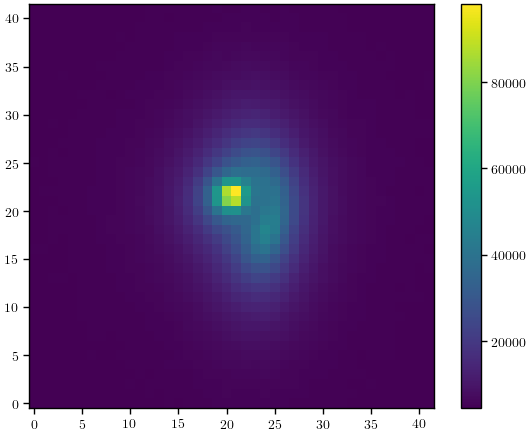

In [14]:
lens_with_subhalo = deepcopy(lens)
lens_with_subhalo.add_subhalo(subhalo_type, kwargs_subhalo)
synth = SyntheticImage(lens_with_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, **config)
exposure = Exposure(synth, exposure_time=exposure_time, rng=rng, **config, poisson_noise=poisson_noise, dark_noise=dark_noise, read_noise=read_noise)

plt.imshow(exposure.exposure)
plt.colorbar()
plt.show()

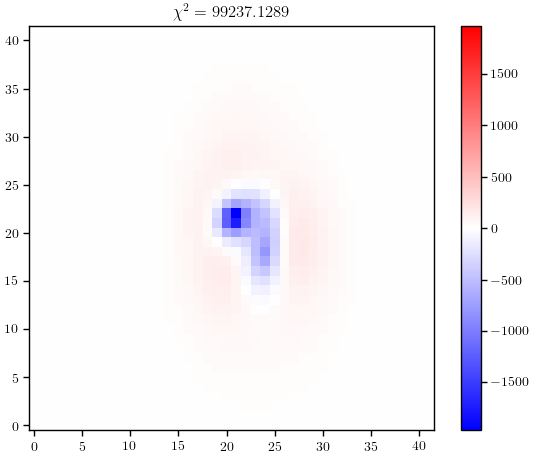

In [15]:
residual = exposure.exposure - exposure_no_subhalo.exposure

chi_square = stats.chi_square(exposure.exposure, exposure_no_subhalo.exposure)

vmax = np.max(np.abs(residual))
plt.imshow(residual, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title(r'$\chi^2=$ ' + f'{chi_square:.4f}')
plt.show()